# Solving an inverse Problem with TorchPhysics and PINNs: Bonus Exercise 8b
Assume you are jumping from a plane with a parachute. Under some simplifications, your fall can be described by the following ODE:
\begin{align*}
    \begin{split}
        \partial_t^2 u(t) &= {\color{red}{D(t)}} \Big[\partial_t u(t)\Big]^2 - g  \text{ for } t\in I_t=[0,T], \\
        u(0) &= H, \\
        \partial_t u(0) &= v_0,
    \end{split}
\end{align*}
where $u : [0, T] \to \mathbb{R}$ is the height at time $t$, $H$ the starting height, $g$ the gravity constant, $v_0$ the initial velocity, and $\color{red}{D(t)}$ a friction coefficient that is proportional to the cross section of the parachute at time $t$.

Given a noisy dataset $\{(u_i, t_i)\}_{i=1}^N$ of the height $u_i$ at time $t_i$, we aim to reconstruct the movement of the parachute described by $\color{red}{D(t)}$.

Again, we use a data condition for learning $u$ from the data. Moreover, since ${\color{red}{D(t)}}$ is only present in the PDE condition, we do not include the remaining conditions for additional loss terms. In other words, we train networks for $u$ and ${\color{red}{D}}$ that minimize
$$
\frac{1}{N}\sum_{i=1}^N \vert u(t_i) - u_i \vert^2 + \frac{1}{M}\sum_{k=1}^M \left\vert \partial_t^2 u(\tilde{t}_k) - {\color{red}{D(\tilde{t}_k)}} \Big[\partial_t u(\tilde{t}_k)\Big]^2 + g \right\vert^2.
$$

In [1]:
import pathlib
import os
gpu_device = str(int(str(pathlib.Path().resolve())[-2:]) % 8)
os.environ["CUDA_VISIBLE_DEVICES"]= gpu_device

In [15]:
import torchphysics as tp
import pytorch_lightning as pl
import torch
import math
from matplotlib import pyplot as plt

# Here all parameters are defined:
g = 9.81                # Gravity constant
H = 0                   # Initial height H
v_0 = -2                # Initial velocity v_0
t_min, t_max = 0.0, 10 # Bounds for time interval

# The groundtruth D(t) that is to be learned
def D_groundtruth(t):
    return 3 * (1.1 + torch.sin(-0.42*t))

### Spaces, domains and samplers

In [3]:
T = tp.spaces.R1('t')
U = tp.spaces.R1('u')
# TODO: Create the output space of parameter function D
D = ...

# TODO: Define the time interval I_t
I_t = ...

# TODO: Create random uniform sampler for the PDE condition, which should hold on I_t. 
#       Use 3000 as the number of sampling points.
pde_sampler = ...

### Load PyTorch dataset $\{(u_i, t_i)\}_{i=1}^N$. 

In [4]:
# Here, we load the data. First, we download it from GitHub ...
!wget https://github.com/TomF98/torchphysics/raw/Berlin-Workshop/examples/SolutionData/Ex_8b/parachute_t_data.pt
!wget https://github.com/TomF98/torchphysics/raw/Berlin-Workshop/examples/SolutionData/Ex_8b/parachute_u_data.pt

# ... then we read it with PyTorch. 't_data' contains points t_i and
#                                   'u_data' the coressponding height u_i.
t_data = torch.load('parachute_t_data.pt')
u_data = torch.load('parachute_u_data.pt')

--2024-11-06 14:20:49--  https://github.com/TomF98/torchphysics/raw/Berlin-Workshop/examples/SolutionData/Ex_8b/parachute_t_data.pt
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TomF98/torchphysics/Berlin-Workshop/examples/SolutionData/Ex_8b/parachute_t_data.pt [following]
--2024-11-06 14:20:50--  https://raw.githubusercontent.com/TomF98/torchphysics/Berlin-Workshop/examples/SolutionData/Ex_8b/parachute_t_data.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1417 (1.4K) [application/octet-stream]
Saving to: 'parachute_t_data.pt.5'

parachute_t_data.pt 100%[===================>]   1.38K  --.-

/tmp/ipykernel_510707/2305262365.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t_data = torch.load('parachute_t_data.pt')
/tmp/ipykernel_510707/2305262365.py:8: Future

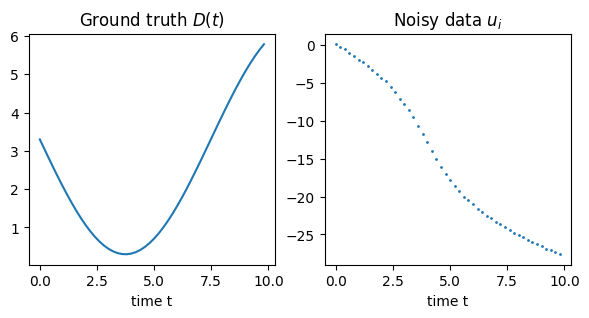

In [5]:
# Plot ground truth parameter D(t) and data u_i
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))
ax1.plot(t_data[:, 0], D_groundtruth(t_data[:, 0]))
ax1.set_title(r'Ground truth $D(t)$')
ax1.set_xlabel('time t')
ax2.scatter(t_data[:, 0], u_data[:, 0], s=1.)
ax2.set_title(r'Noisy data $u_i$')
ax2.set_xlabel('time t')
plt.show()

In [ ]:
# TODO: In order to work with the data in TorchPhysics,
#       we need to transform the data into `tp.spaces.Points` objects.
t_data_points = ...
u_data_points = ...

# TODO: Create a DataLoader, that loads combinations of t_data_points and u_data_points.
# Hint: This is analogous to Exercise_8.
data_loader = tp.utils.PointsDataLoader(..., batch_size=len(t_data))

### Proceed with familiar TorchPhysics pipeline: Create models, residual functions and conditions

In [ ]:
# We use the same model archiecture for u as in Exercise 8
model_u = tp.models.FCN(input_space=T, output_space=U, hidden = (50, 50))

# TODO: Create a FCN for the parameter function D(t). Use hidden=(30, 30, 30)
model_D = ...

# TODO: We want to train the model for u and for D in parallel. For that, pass them as inputs to tp.models.Parallel
model = ...

In [ ]:
# TODO: Create a residual for the PDE condition
def pde_residual(...):
  return ...

# TODO: Create corresponding TorchPhysics condition. 
#       Note that the parallel model for u and D should be trained on this condition.
pde_condition = ...

In [ ]:
# TODO: Again, we need a data condition, which is analogous to Exercise 8.
data_condition = tp.conditions.DataCondition(module=...,
                                             dataloader=...,
                                             norm=2,
                                             use_full_dataset=True,
                                             weight=50)

### Training with the Adam optimizer

In [10]:
# Training parameters for ADAM optimizer
train_iterations = 5000
learning_rate = 1.e-3

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=learning_rate)
solver = tp.solver.Solver(train_conditions=[data_condition, pde_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu", # use one GPU
                     max_steps=train_iterations, # iteration number
                     benchmark=True, # faster if input batch has constant size
                     logger=False, # for writting into tensorboard
                     enable_checkpointing=False)

trainer.fit(solver)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | train_conditions | ModuleList | 4.7 K  | train
1 | val_conditions   | ModuleList | 0      | train
--------------------------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


/localdata/komso/komso01/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.
/localdata/komso/komso01/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 5000/5000 [01:37<00:00, 51.45it/s, train/loss=0.130] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 5000/5000 [01:37<00:00, 51.45it/s, train/loss=0.130]

`Trainer.fit` stopped: `max_steps=5000` reached.


Epoch 0: 100%|██████████| 5000/5000 [01:37<00:00, 51.45it/s, train/loss=0.130]


In [ ]:
# We plot the parameter function D that we learned
from matplotlib import pyplot as plt

plot_domain = tp.domains.Interval(T, t_min, t_max)
plot_sampler = tp.samplers.PlotSampler(plot_domain, 1000)
fig = tp.utils.plot(model_D, lambda D: D, plot_sampler, label=r'Trained parameter $D$')

# Plot ground truth D(t)
ts = torch.linspace(t_min, t_max, 1000)
plt.plot(ts, D_groundtruth(ts), label=r'Ground truth $D$')
plt.legend()
plt.show()

In [ ]:
# Plot learned solution u(t)
plot_domain = tp.domains.Interval(T, t_min, t_max)
plot_sampler = tp.samplers.PlotSampler(plot_domain, 1000)
fig = tp.utils.plot(model_u, lambda u: u, plot_sampler, label=r'Learned solution $u$')
plt.scatter(torch.linspace(t_min, t_max, len(u_data)), u_data, zorder=1, label='Noisy data u_i', c='r')
plt.legend()
plt.show()

### Improve the results by using LBFGS

In [12]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.1, optimizer_args={'max_iter': 3})
pde_condition.sampler = tp.samplers.GridSampler(I_t, 3000).make_static() # We use a static sampler to save time (static means: points are sampled beforehand and not every training step)
solver = tp.solver.Solver([data_condition, pde_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     max_steps=1000,
                     logger=False,
                     benchmark=True)

trainer.fit(solver)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/localdata/komso/komso01/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /localdata/komso/komso01/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | train_conditions | ModuleList | 4.7 K  | train
1 | val_conditions   | ModuleList | 0      | train
--------------------------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1000/1000 [01:12<00:00, 13.74it/s, train/loss=0.116]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 1000/1000 [01:12<00:00, 13.74it/s, train/loss=0.116]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 0: 100%|██████████| 1000/1000 [01:12<00:00, 13.72it/s, train/loss=0.116]


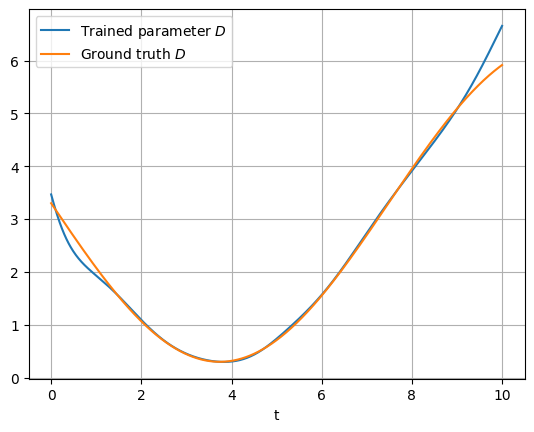

In [13]:
# We plot the parameter function D that we learned
from matplotlib import pyplot as plt

plot_domain = tp.domains.Interval(T, t_min, t_max)
plot_sampler = tp.samplers.PlotSampler(plot_domain, 1000)
fig = tp.utils.plot(model_D, lambda D: D, plot_sampler, label=r'Trained parameter $D$')

# Plot ground truth D(t)
ts = torch.linspace(t_min, t_max, 1000)
plt.plot(ts, D_groundtruth(ts), label=r'Ground truth $D$')
plt.legend()
plt.show()

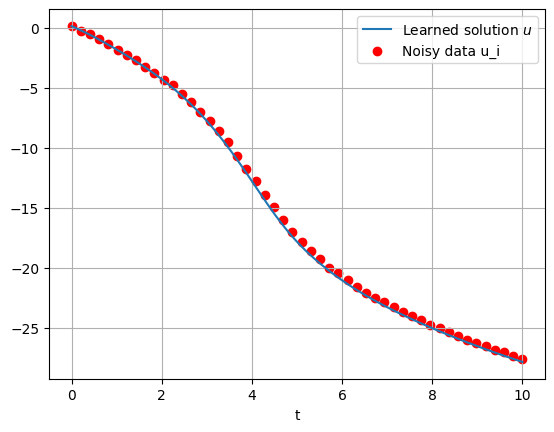

In [14]:
# Plot learned solution u(t)
plot_domain = tp.domains.Interval(T, t_min, t_max)
plot_sampler = tp.samplers.PlotSampler(plot_domain, 1000)
fig = tp.utils.plot(model_u, lambda u: u, plot_sampler, label=r'Learned solution $u$')
plt.scatter(torch.linspace(t_min, t_max, len(u_data)), u_data, zorder=1, label='Noisy data u_i', c='r')
plt.legend()
plt.show()